From the code for the following article [Sub-sampling for Efficient Non-Parametric Bandit Exploration](https://arxiv.org/abs/2010.14323)

## Nonparametric Thompson Sampling (NP-TS)

NP-TS consists of randomly reweighting the history of rewards for each arm at each round and comparing their empirical averages w.r.t to these random weights. To do so, the weights are drawn from a Dirichlet distribution (uniform on the $N_k(t)$-simplex for arm $k$ at round $t$). 

This procedure is subject to a trivial exploration defect however: for instance, if the optimal arm gets unlucky in the first rounds so that its best reward is worse than the worst observed reward of another suboptimal arm, then the convex combination of its rewards will always be less than that of that arm, regardless of the sampled weights from the Dirichlet distribution. 

To avoid this degenerate case and promote a healthy amount of exploration, NP-TS introduces a perturbed reward history by systematically adding the upper bound of the support, so that a convex combination of the surrogate reward history may span all the range up to the upper bound. 

However, this technique locks NP-TS in the setting of bounded reward distribution with known upper bounds. It is therefore not *fully* nonparametric as it requires some knowledge of the support. 

This notebook explores an alternative techniques, that is perturbating the reward history at round $t$ with $M_t = \max_{k\in[K], s<t} X_{A_s, s}$, i.e the running maximum across all observed reward ($A_s$ denotes the arm selected by the policy at round $s$).

Note: shown below are the cumulative regret average across independent runs, with confidence bounds based on the 5% and 95% empirical quantiles across MC simulations).

In [1]:
from IPython.core.display import HTML
display(HTML('<style>.container { width:95% !important; } </style>'))

%load_ext autoreload
%autoreload 2

In [2]:
from MAB import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Parameters and aliases for all algorithms

In [3]:
# Enter the parameters of each algorithms
param = {'non_parametric_TS': {}}

mapping = {'B': BetaBernoulliMAB, 'C': CauchyMAB, 'U': UniformMAB, 'G': GaussianMAB, 'LG': LogGaussianMAB, 'Exp': ExponentialMAB, 'TG': TruncGaussianMAB}
mapping_name = {'B': 'Bernoulli', 'C': 'Cauchy', 'U': 'Uniform', 'G': 'Gaussian', 'LG': 'LogGaussian', 'Exp': 'Exponential', 'TG': 'Truncated Gaussian'}

T = 1000  # Horizon
N = 100  # Number of MC runs
step = 25  # If results are saved trajectories are stored for all rounds such that t%step=0

In [4]:
def get_confidence_bounds(all_r, r=None, step=None, confidence_type='quantile'):
    """Compute confidence bounds for an array of (T/step, N) results.
    """
    if confidence_type == 'std':
        r_std = np.std(all_r, axis=1)
        r_conf_inf = r[::step] - 1.96 * r_std
        r_conf_sup = r[::step] + 1.96 * r_std
    elif confidence_type == 'quantile':
        r_conf_inf = np.quantile(all_r, 0.05, axis=1)
        r_conf_sup = np.quantile(all_r, 0.95, axis=1)
    else:
        raise ValueError('Unknown confidence type: {:s}'.format(confidence_type))
        
    return r_conf_inf, r_conf_sup

### Bounded arms

* Similar regret between exact NP-TS and the empirical maximum version, without the knowledge of the optimal upper bound

In [5]:
bandit = 'B'
p = [0.7, 0.5]  # parameters for the arms distribution

model = mapping[bandit](p)

r_1, all_r_1 = model.MC_regret('non_parametric_TS', N, T, {'upper_bound': 1.0}, step)
r_2, all_r_2 = model.MC_regret('non_parametric_TS', N, T, {'upper_bound': None}, step)

all_r = [r_1, r_2]

res = pd.DataFrame(all_r).T
res.columns = ['NP-TS', 'NP-TS (unknown bound)']

r_1_conf_inf, r_1_conf_sup = get_confidence_bounds(all_r_1, r=r_1, step=step, confidence_type='quantile')
r_2_conf_inf, r_2_conf_sup = get_confidence_bounds(all_r_2, r=r_2, step=step, confidence_type='quantile')

all_r_conf_inf = [r_1_conf_inf, r_2_conf_inf]
all_r_conf_sup = [r_1_conf_sup, r_2_conf_sup]

res_conf_inf = pd.DataFrame(all_r_conf_inf).T
res_conf_sup = pd.DataFrame(all_r_conf_sup).T
res_conf_inf.columns = ['NP-TS', 'NP-TS (unknown bound)']
res_conf_sup.columns = ['NP-TS', 'NP-TS (unknown bound)']

Computing 100 simulations: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


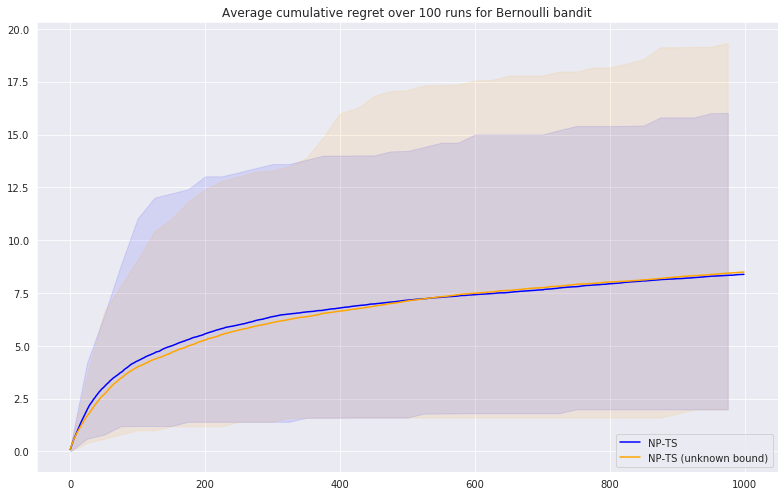

In [6]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(11, 7), nrows=1, ncols=1)
    
    colors = ['blue', 'orange']
    
    for i, col in enumerate(res.columns):
        res[col].plot(ax=ax, color=colors[i])
        ax.fill_between(
            res.index[::step], 
            res_conf_inf[col], 
            res_conf_sup[col],
            color=colors[i],
            alpha=0.1,
        )
    
    ax.legend(loc='lower right')
    ax.set_title('Average cumulative regret over {} runs for {:s} bandit'.format(N, mapping_name[bandit]))

    plt.tight_layout()
    plt.show()

### Unbounded arms (Gaussian)

In [7]:
bandit = 'G'
p = [[0.6, 0.5], [0.7, 0.3]]  # parameters for the arms distribution

model = mapping[bandit](p)

r_1, all_r_1 = model.MC_regret('non_parametric_TS', N, T, {'upper_bound': 1.0}, step)
r_2, all_r_2 = model.MC_regret('non_parametric_TS', N, T, {'upper_bound': None}, step)

all_r = [r_1, r_2]

res = pd.DataFrame(all_r).T
res.columns = ['NP-TS', 'NP-TS (unknown bound)']

r_1_conf_inf, r_1_conf_sup = get_confidence_bounds(all_r_1, r=r_1, step=step, confidence_type='quantile')
r_2_conf_inf, r_2_conf_sup = get_confidence_bounds(all_r_2, r=r_2, step=step, confidence_type='quantile')

all_r_conf_inf = [r_1_conf_inf, r_2_conf_inf]
all_r_conf_sup = [r_1_conf_sup, r_2_conf_sup]

res_conf_inf = pd.DataFrame(all_r_conf_inf).T
res_conf_sup = pd.DataFrame(all_r_conf_sup).T
res_conf_inf.columns = ['NP-TS', 'NP-TS (unknown bound)']
res_conf_sup.columns = ['NP-TS', 'NP-TS (unknown bound)']

Computing 100 simulations: 100%|██████████| 100/100 [00:13<00:00,  7.18it/s]


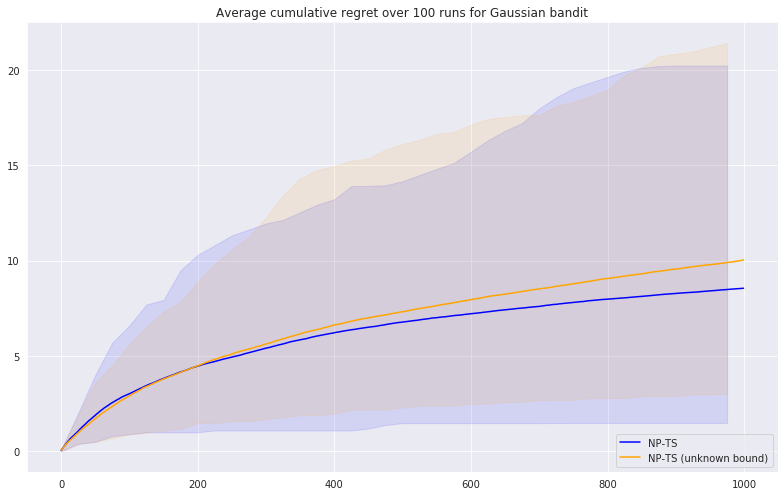

In [8]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(11, 7), nrows=1, ncols=1)
    
    colors = ['blue', 'orange']
    
    for i, col in enumerate(res.columns):
        res[col].plot(ax=ax, color=colors[i])
        ax.fill_between(
            res.index[::step], 
            res_conf_inf[col], 
            res_conf_sup[col],
            color=colors[i],
            alpha=0.1,
        )
    
    ax.legend(loc='lower right')
    ax.set_title('Average cumulative regret over {} runs for {:s} bandit'.format(N, mapping_name[bandit]))

    plt.tight_layout()
    plt.show()

### Unbounded arms (Exponential)

In [9]:
bandit = 'Exp'
p = [1.0, 0.8]  # parameters for the arms distribution

model = mapping[bandit](p)

r_1, all_r_1 = model.MC_regret('non_parametric_TS', N, T, {'upper_bound': 1.0}, step)
r_2, all_r_2 = model.MC_regret('non_parametric_TS', N, T, {'upper_bound': None}, step)

all_r = [r_1, r_2]

res = pd.DataFrame(all_r).T
res.columns = ['NP-TS', 'NP-TS (unknown bound)']

r_1_conf_inf, r_1_conf_sup = get_confidence_bounds(all_r_1, r=r_1, step=step, confidence_type='quantile')
r_2_conf_inf, r_2_conf_sup = get_confidence_bounds(all_r_2, r=r_2, step=step, confidence_type='quantile')

all_r_conf_inf = [r_1_conf_inf, r_2_conf_inf]
all_r_conf_sup = [r_1_conf_sup, r_2_conf_sup]

res_conf_inf = pd.DataFrame(all_r_conf_inf).T
res_conf_sup = pd.DataFrame(all_r_conf_sup).T
res_conf_inf.columns = ['NP-TS', 'NP-TS (unknown bound)']
res_conf_sup.columns = ['NP-TS', 'NP-TS (unknown bound)']

Computing 100 simulations: 100%|██████████| 100/100 [00:13<00:00,  7.16it/s]


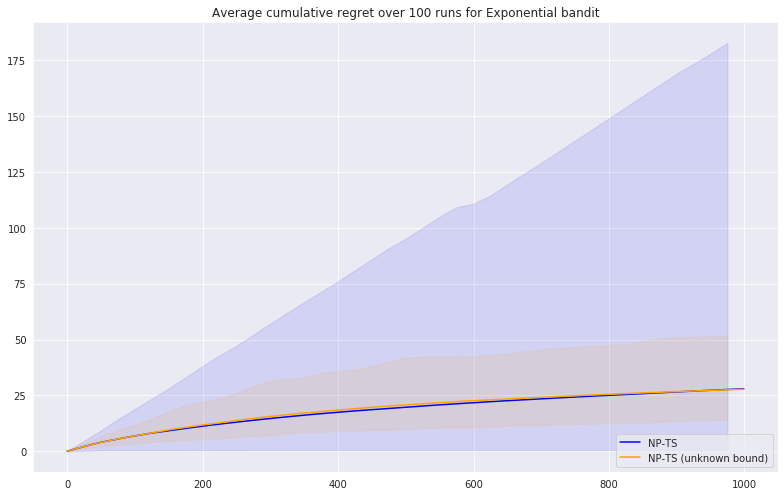

In [10]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(11, 7), nrows=1, ncols=1)
    
    colors = ['blue', 'orange']
    
    for i, col in enumerate(res.columns):
        res[col].plot(ax=ax, color=colors[i])
        ax.fill_between(
            res.index[::step], 
            res_conf_inf[col], 
            res_conf_sup[col],
            color=colors[i],
            alpha=0.1,
        )
    
    ax.legend(loc='lower right')
    ax.set_title('Average cumulative regret over {} runs for {:s} bandit'.format(N, mapping_name[bandit]))

    plt.tight_layout()
    plt.show()

### Unbounded arms (Lognormal --> heavy tail)

Due to the heavy right tail, a fixed bound NP-TS does not guarantee enough exploration. The running maximum version seems to exhibit a linear regret too, albeit at a smaller rate.

In [11]:
bandit = 'LG'
p = [[0.2, 0.3], [0.2, 0.25]]  # parameters for the arms distribution

model = mapping[bandit](p)

r_1, all_r_1 = model.MC_regret('non_parametric_TS', N, T, {'upper_bound': 1.0}, step)
r_2, all_r_2 = model.MC_regret('non_parametric_TS', N, T, {'upper_bound': None}, step)

all_r = [r_1, r_2]

res = pd.DataFrame(all_r).T
res.columns = ['NP-TS', 'NP-TS (unknown bound)']

r_1_conf_inf, r_1_conf_sup = get_confidence_bounds(all_r_1, r=r_1, step=step, confidence_type='quantile')
r_2_conf_inf, r_2_conf_sup = get_confidence_bounds(all_r_2, r=r_2, step=step, confidence_type='quantile')

all_r_conf_inf = [r_1_conf_inf, r_2_conf_inf]
all_r_conf_sup = [r_1_conf_sup, r_2_conf_sup]

res_conf_inf = pd.DataFrame(all_r_conf_inf).T
res_conf_sup = pd.DataFrame(all_r_conf_sup).T
res_conf_inf.columns = ['NP-TS', 'NP-TS (unknown bound)']
res_conf_sup.columns = ['NP-TS', 'NP-TS (unknown bound)']

Computing 100 simulations: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


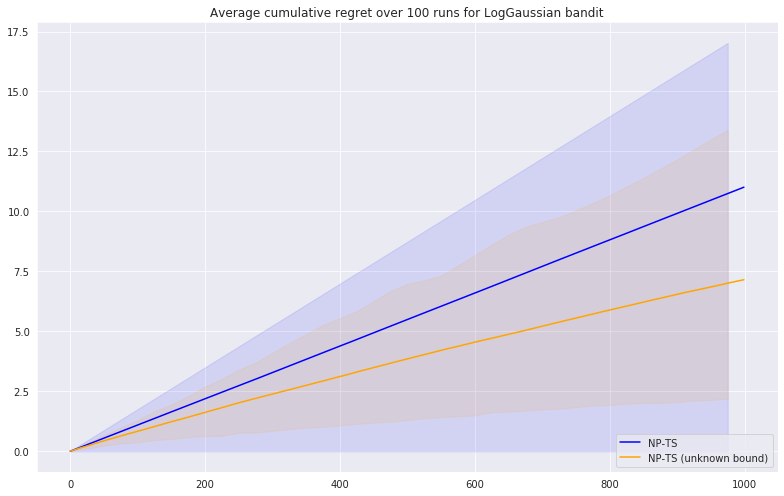

In [12]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(11, 7), nrows=1, ncols=1)
    
    colors = ['blue', 'orange']
    
    for i, col in enumerate(res.columns):
        res[col].plot(ax=ax, color=colors[i])
        ax.fill_between(
            res.index[::step], 
            res_conf_inf[col], 
            res_conf_sup[col],
            color=colors[i],
            alpha=0.1,
        )
    
    ax.legend(loc='lower right')
    ax.set_title('Average cumulative regret over {} runs for {:s} bandit'.format(N, mapping_name[bandit]))

    plt.tight_layout()
    plt.show()

### Unbounded arms (Cauchy -> not even a proper bandit with integrable arms! Limit case where exploration bias in the form of the empirical maximum does not vanish through averaging)

The Cauchy distribution belongs to the Frechet attraction domain of extreme values, that is if $(X_n)_{n\in\mathbb{N}}$ is an i.i.d sequence of Cauchy variables, $M_n=\max_{i=1, \dots, n}$ and $F$ denotes the Cauchy cdf, then (Fisher-Tippet-Gnedenko) $\frac{M_n}{F^{-1}(1-\frac{1}{n})}$ converges in law to a Frechet distribution. In the case of Cauchy variables specifically, $F^{-1}(1-\frac{1}{n})$ behaves like $n$ when $n\to +\infty$, which means the contribution of $M_n$ in the weighted average does not disapear.

This is a case where empirical max NP-TS (and most methods actually) should (and does) fail.

In [13]:
bandit = 'C'
p = [[0.0, 1.0], [0.5, 0.1]]  # parameters for the arms distribution (mode and scale rather than mean and standard deviation)

model = mapping[bandit](p)

r_1, all_r_1 = model.MC_regret('non_parametric_TS', N, T, {'upper_bound': 1.0}, step)
r_2, all_r_2 = model.MC_regret('non_parametric_TS', N, T, {'upper_bound': None}, step)

all_r = [r_1, r_2]

res = pd.DataFrame(all_r).T
res.columns = ['NP-TS', 'NP-TS (unknown bound)']

r_1_conf_inf, r_1_conf_sup = get_confidence_bounds(all_r_1, r=r_1, step=step, confidence_type='quantile')
r_2_conf_inf, r_2_conf_sup = get_confidence_bounds(all_r_2, r=r_2, step=step, confidence_type='quantile')

all_r_conf_inf = [r_1_conf_inf, r_2_conf_inf]
all_r_conf_sup = [r_1_conf_sup, r_2_conf_sup]

res_conf_inf = pd.DataFrame(all_r_conf_inf).T
res_conf_sup = pd.DataFrame(all_r_conf_sup).T
res_conf_inf.columns = ['NP-TS', 'NP-TS (unknown bound)']
res_conf_sup.columns = ['NP-TS', 'NP-TS (unknown bound)']

Computing 100 simulations: 100%|██████████| 100/100 [00:21<00:00,  4.75it/s]


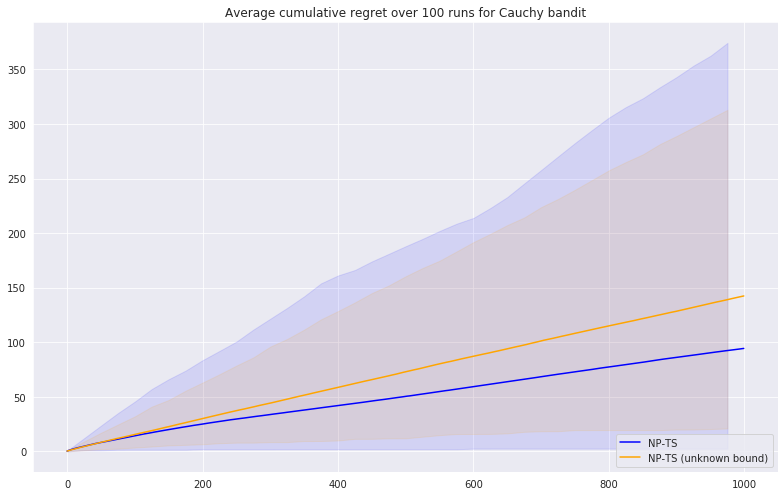

In [14]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(11, 7), nrows=1, ncols=1)
    
    colors = ['blue', 'orange']
    
    for i, col in enumerate(res.columns):
        res[col].plot(ax=ax, color=colors[i])
        ax.fill_between(
            res.index[::step], 
            res_conf_inf[col], 
            res_conf_sup[col],
            color=colors[i],
            alpha=0.1,
        )
    
    ax.legend(loc='lower right')
    ax.set_title('Average cumulative regret over {} runs for {:s} bandit'.format(N, mapping_name[bandit]))

    plt.tight_layout()
    plt.show()

### Uniform arms with different support

* Works equally as well as NP-TS, without the knowledge of the optimal upper bound

#### Optimal arm has large support

In [15]:
bandit = 'U'  # 'B', 'G', 'LG', 'Exp', 'TG'
p = [[0.0, 1.0], [0.2, 0.4]]  # parameters for the arms distribution

model = mapping[bandit](p)

r_1, all_r_1 = model.MC_regret('non_parametric_TS', N, T, {'upper_bound': 1.0}, step)
r_2, all_r_2 = model.MC_regret('non_parametric_TS', N, T, {'upper_bound': None}, step)

all_r = [r_1, r_2]

res = pd.DataFrame(all_r).T
res.columns = ['NP-TS', 'NP-TS (unknown bound)']

r_1_conf_inf, r_1_conf_sup = get_confidence_bounds(all_r_1, r=r_1, step=step, confidence_type='quantile')
r_2_conf_inf, r_2_conf_sup = get_confidence_bounds(all_r_2, r=r_2, step=step, confidence_type='quantile')

all_r_conf_inf = [r_1_conf_inf, r_2_conf_inf]
all_r_conf_sup = [r_1_conf_sup, r_2_conf_sup]

res_conf_inf = pd.DataFrame(all_r_conf_inf).T
res_conf_sup = pd.DataFrame(all_r_conf_sup).T
res_conf_inf.columns = ['NP-TS', 'NP-TS (unknown bound)']
res_conf_sup.columns = ['NP-TS', 'NP-TS (unknown bound)']

Computing 100 simulations: 100%|██████████| 100/100 [00:13<00:00,  7.36it/s]


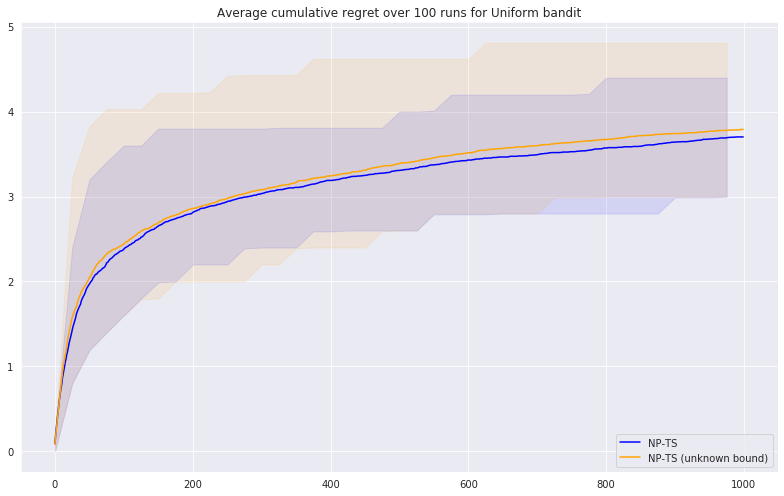

In [16]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(11, 7), nrows=1, ncols=1)
    
    colors = ['blue', 'orange']
    
    for i, col in enumerate(res.columns):
        res[col].plot(ax=ax, color=colors[i])
        ax.fill_between(
            res.index[::step], 
            res_conf_inf[col], 
            res_conf_sup[col],
            color=colors[i],
            alpha=0.1,
        )
    
    ax.legend(loc='lower right')
    ax.set_title('Average cumulative regret over {} runs for {:s} bandit'.format(N, mapping_name[bandit]))

    plt.tight_layout()
    plt.show()

#### Optimal arm has narrow support

In [17]:
bandit = 'U'  # 'B', 'G', 'LG', 'Exp', 'TG'
p = [[0.0, 1.0], [0.6, 0.8]]  # parameters for the arms distribution

model = mapping[bandit](p)

r_1, all_r_1 = model.MC_regret('non_parametric_TS', N, T, {'upper_bound': 1.0}, step)
r_2, all_r_2 = model.MC_regret('non_parametric_TS', N, T, {'upper_bound': None}, step)

all_r = [r_1, r_2]

res = pd.DataFrame(all_r).T
res.columns = ['NP-TS', 'NP-TS (unknown bound)']

r_1_conf_inf, r_1_conf_sup = get_confidence_bounds(all_r_1, r=r_1, step=step, confidence_type='quantile')
r_2_conf_inf, r_2_conf_sup = get_confidence_bounds(all_r_2, r=r_2, step=step, confidence_type='quantile')

all_r_conf_inf = [r_1_conf_inf, r_2_conf_inf]
all_r_conf_sup = [r_1_conf_sup, r_2_conf_sup]

res_conf_inf = pd.DataFrame(all_r_conf_inf).T
res_conf_sup = pd.DataFrame(all_r_conf_sup).T
res_conf_inf.columns = ['NP-TS', 'NP-TS (unknown bound)']
res_conf_sup.columns = ['NP-TS', 'NP-TS (unknown bound)']

Computing 100 simulations: 100%|██████████| 100/100 [00:16<00:00,  5.96it/s]


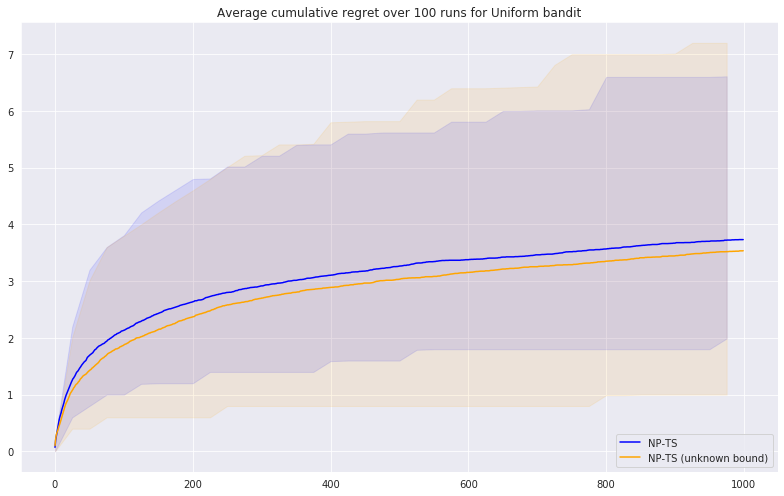

In [18]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(11, 7), nrows=1, ncols=1)
    
    colors = ['blue', 'orange']
    
    for i, col in enumerate(res.columns):
        res[col].plot(ax=ax, color=colors[i])
        ax.fill_between(
            res.index[::step], 
            res_conf_inf[col], 
            res_conf_sup[col],
            color=colors[i],
            alpha=0.1,
        )
    
    ax.legend(loc='lower right')
    ax.set_title('Average cumulative regret over {} runs for {:s} bandit'.format(N, mapping_name[bandit]))

    plt.tight_layout()
    plt.show()